# Preprocessing Steps
This notebook provides the preprocessing steps necessary for the preparation of both target and non-target object images from the ImageNet dataset. The process involves the following key stages:

- Object Segmentation: We utilize SAM model to accurately segment objects from the ImageNet dataset. 
- Manual Screening: After the initial segmentation, a manual screening process is employed to assess and ensure the quality of the segmented objects. 
- Final Resizing and Padding: Once the high-quality object segments are obtained, we perform a final step of resizing and padding to standardize their dimensions.

# Load libraries and index files

In [1]:
import json 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
from tqdm import tqdm
from pathlib import Path
import math



In [2]:
# image dataset path
DIR_SOURCEIMG = Path('../data/ilsvrc/val')
SAVE_SEGMENTATED = Path('../data/imagenet_val_segmented')
SAVE_MASK = Path('../data/imagenet_val_mask')

# load json file
with open('../dataset-info/imagenet_class_index.json') as f:
    imagenet_class_index_dict = json.load(f)


# Restricted Imagenet Range 
# https://github.com/MadryLab/robustness/blob/a9541241defd9972e9334bfcdb804f6aefe24dc7/robustness/tools/constants.py#L7
# dog (117), cat (5), frog (3), turtle (5), bird (21), 
# monkey (14), fish (9), crab (4), insect (20) 
RESTRICTED_IMAGNET_RANGES = [(151, 267), (281, 285), 
        (30, 32), (33, 37), (80, 100), (365, 382),
          (389, 397), (118, 121), (300, 319)]


class2label = {-1: 'noise', 0: 'dog', 1: 'cat', 
        2: 'frog', 3: 'turtle', 4: 'bird', 
        5: 'primate', 6: 'fish', 7: 'crab', 
        8: 'insect'}

label2class = dict((v,k) for k,v in class2label.items())

## Set-up and load SAM

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [23]:
using_colab = False
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [24]:
# load SAM model
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "../checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

KeyboardInterrupt: 

## A single image example

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [ ]:
# get target synset and label
target =  'frog'
target_range = RESTRICTED_IMAGNET_RANGES[label2class[target]]

target_synset = []
target_label = []
for i in range(target_range[0],target_range[1]+1):
    synset, label = imagenet_class_index_dict[str(i)]
    target_synset.append(synset)
    target_label.append(label)

print(len(target_synset))
print(target_label)

# get imagelist for target
for synset in target_synset:
    path_synset = DIR_SOURCEIMG/synset
    imagelist = os.listdir(path_synset)
    break

# select 20 images from imagelist and visualize using matplotlib
# random.shuffle(imagelist)
# fig = plt.figure(figsize=(20, 10))
# columns = 5
# rows = 4
# for i in range(1, columns*rows +1):
#     img = mpimg.imread(os.path.join(path_synset, imagelist[i]))
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)


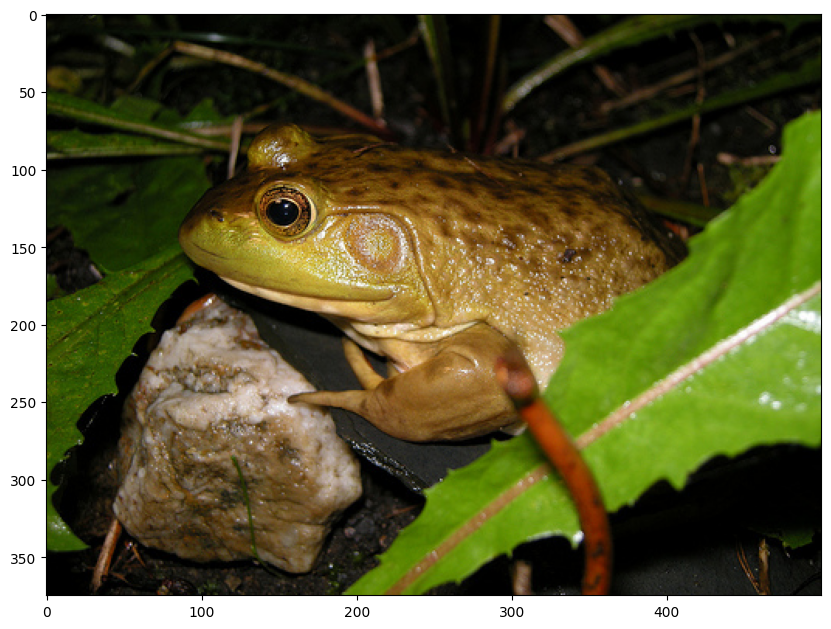

In [ ]:
random.shuffle(imagelist)
imgpath = os.path.join(path_synset, imagelist[0])
image = cv2.imread(imgpath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

# show image
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

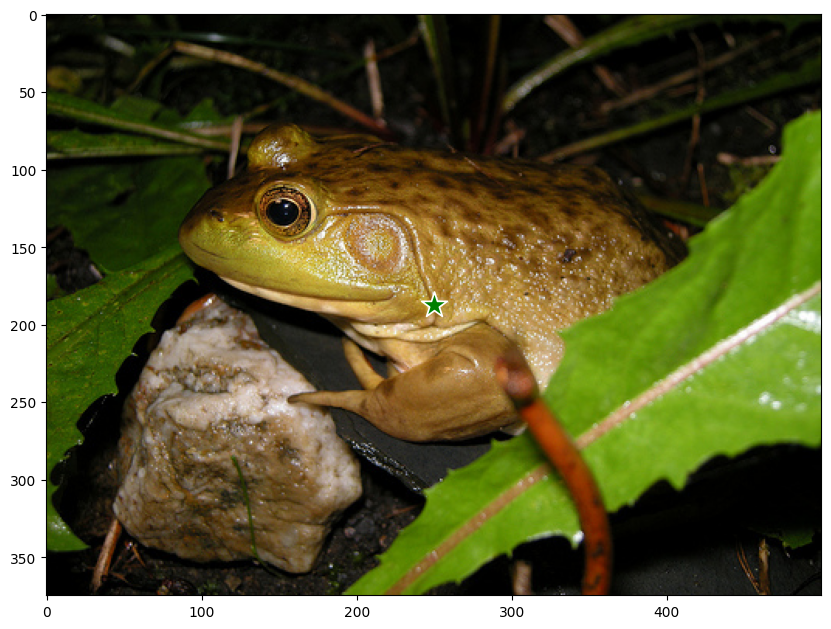

In [ ]:
# select a center point
input_point = np.array([[int(image.shape[1]/2), int(image.shape[0]/2)]])
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

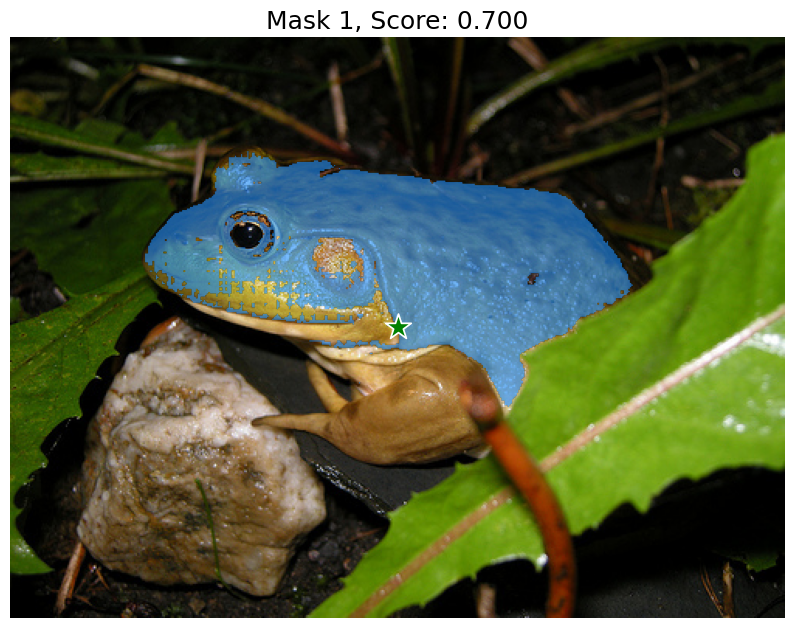

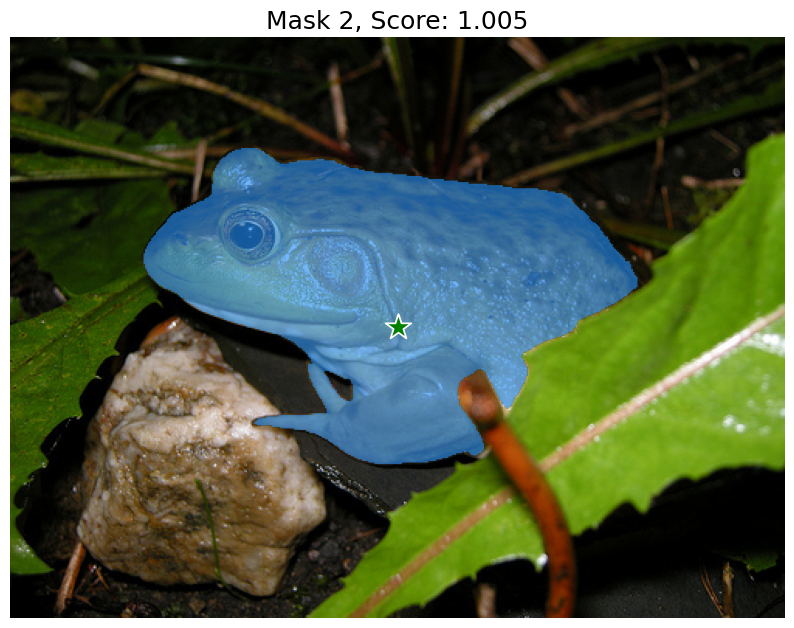

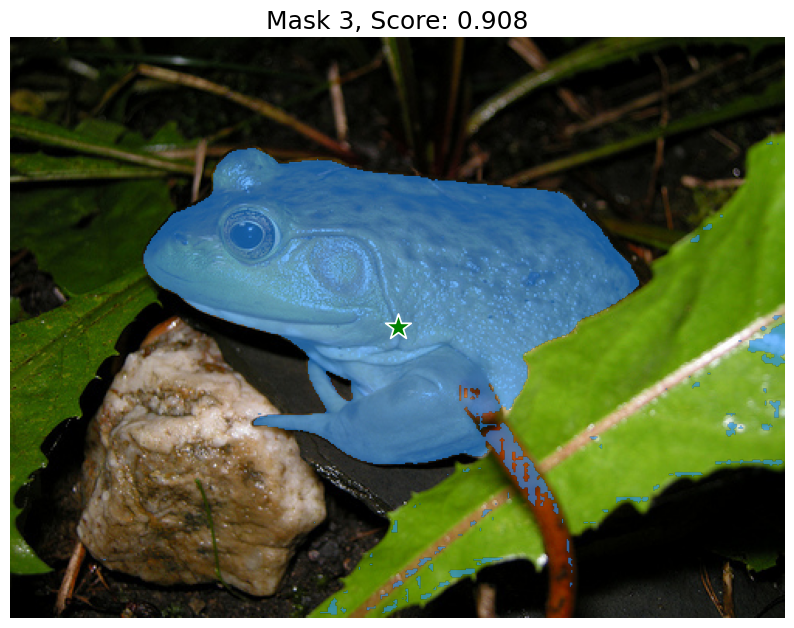

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

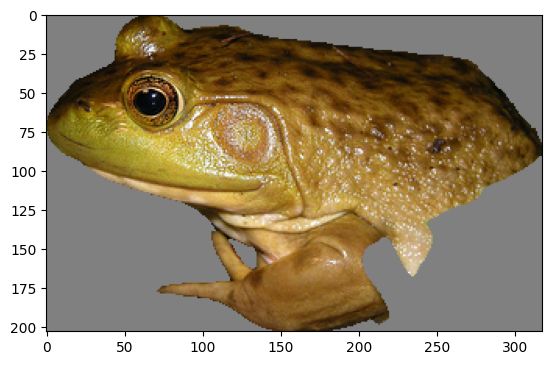

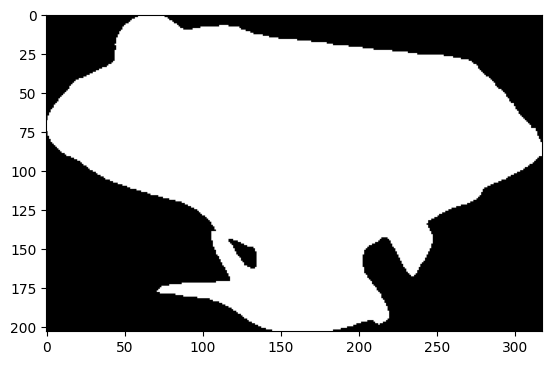

In [ ]:
# Select best mask 
mask_idx = np.argmax(scores) # choose score is high
segmentation = np.where(masks[mask_idx] == True)


# Bounding Box
bbox = 0, 0, 0, 0
if len(segmentation) != 0 and len(segmentation[1]) != 0 and len(segmentation[0]) != 0:
    x_min = int(np.min(segmentation[1]))
    x_max = int(np.max(segmentation[1]))
    y_min = int(np.min(segmentation[0]))
    y_max = int(np.max(segmentation[0]))

    bbox = x_min, x_max, y_min, y_max

# change background color
BACKGROUND_COLOR = 128
image[~masks[mask_idx]]= BACKGROUND_COLOR
# plt.imshow(image)
# plt.show()

cropped_image = image[y_min:y_max, x_min:x_max]
plt.imshow(cropped_image)
plt.show()

cropped_mask = masks[mask_idx][y_min:y_max, x_min:x_max]
plt.imshow(cropped_mask, vmax=1, vmin=0, cmap='gray')
plt.show()

# Apply to dataset and save masks and images

In [ ]:
# check if SAVE_SEGMENTATED exists and if exists ask user to overwrite or not
if os.path.exists(SAVE_SEGMENTATED):
    raise ValueError(f'{SAVE_SEGMENTATED} already exists, check whether you want to overwrite or not')

# get target synset and label
# ['dog', 'cat', 'frog', 'turtle', 'bird', 'primate', 'fish', 'crab', 'insect', 'nontarget']:
target =  'insertsomecategoryhere' 
if target == 'nontarget':

    allowed_numbers = []
    for num in range(1000):
        is_allowed = True
        for start, end in RESTRICTED_IMAGNET_RANGES:
            if start <= num <= end+1:
                is_allowed = False
                break
        if is_allowed:
            allowed_numbers.append(num)
    target_index_list = allowed_numbers
    target_index_list = [124]


else:
    target_index_list = list(range(RESTRICTED_IMAGNET_RANGES[label2class[target]][0], RESTRICTED_IMAGNET_RANGES[label2class[target]][1]+1))

target_synset = []
target_label = []
for i in target_index_list:
    synset, label = imagenet_class_index_dict[str(i)]
    target_synset.append(synset)
    target_label.append(label)

print('target: ', target)
print('# of synsets belong to this category', len(target_synset))
print(target_synset)
print(target_label)
# assert False


# if not exist create folder for saving generated images
save_path_segmented = SAVE_SEGMENTATED/target
save_path_mask = SAVE_MASK/target
if not os.path.exists(save_path_segmented):
    os.makedirs(save_path_segmented)
if not os.path.exists(save_path_mask):
    os.makedirs(save_path_mask)
    

# get imagelist for each target
for synset in tqdm(target_synset):
    path_synset = DIR_SOURCEIMG/synset
    imagelist = os.listdir(path_synset)
    imagelist = [imgpath for imgpath in imagelist if imgpath.endswith('.JPEG')]
    
    # print(f'generating segmented target on {synset}', len(imagelist))

    for imagename in imagelist:
        
        # get image
        imgpath = os.path.join(path_synset, imagename)
        image = cv2.imread(imgpath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        predictor.set_image(image)
        
        # select a center point
        input_point = np.array([[int(image.shape[1]/2), int(image.shape[0]/2)]])
        input_label = np.array([1])
        
        # run sam
        masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True,
        )

        # Select the best mask 
        mask_idx = np.argmax(scores) # choose score is high
        segmentation = np.where(masks[mask_idx] == True)

        # Bounding Box
        bbox = 0, 0, 0, 0
        if len(segmentation) != 0 and len(segmentation[1]) != 0 and len(segmentation[0]) != 0:
            x_min = int(np.min(segmentation[1]))
            x_max = int(np.max(segmentation[1]))
            y_min = int(np.min(segmentation[0]))
            y_max = int(np.max(segmentation[0]))

            bbox = x_min, x_max, y_min, y_max

        # change background color
        BACKGROUND_COLOR = 128
        image[~masks[mask_idx]]= BACKGROUND_COLOR
        # plt.imshow(image)
        # plt.show()

        cropped_image = image[y_min:y_max, x_min:x_max]
        cropped_mask = masks[mask_idx][y_min:y_max, x_min:x_max]

        plt.imsave(os.path.join(save_path_segmented, f'{synset}_{imagename}'), cropped_image)
        plt.imsave(os.path.join(save_path_mask, f'{synset}_{imagename}'), cropped_mask)

print('done!')


ValueError: ../data/imagenet_val_segmented already exists, check whether you want to overwrite or not

# resize images with padding

In [34]:
from PIL import Image,  ImageOps, ImageEnhance, ImageFilter

def pad_and_resize_image(image, output_size, background_color=255, extrapixels=30):
    '''
    input: PIL image
    '''
    # pad to square
    maxlength = max(image.size)
    if image.mode == '1':
        background = Image.new("1", (maxlength, maxlength)) # default fill is black
    else:
        background = Image.new("RGB", (maxlength, maxlength), (background_color, background_color, background_color))
    offset = ((maxlength-image.size[0]) // 2, (maxlength - image.size[1]) // 2)
    background.paste(image, offset, image)
    
    # resize
    resized_image = background.resize(output_size)
    if image.mode == '1':
        out_image = ImageOps.expand(resized_image, border=extrapixels) # default fill is black
    else:
        out_image = ImageOps.expand(resized_image, border=extrapixels, fill= (background_color, background_color, background_color))
    return out_image


VISUALIZE = False
SAVE_OUTPUT = True
BACKGROUND_COLOR = 128 # 255 white or 128 gray
OUTPUT_SIZE = (180, 180) # object size in pixels , width x height
EXTRAPIXELS= 30 # extra pixels for padding --> 180 * 30x2 = 240 pixels
SAVE_IMG_RESIZED = Path('../data/imagenet_val_segmented_resized')
SAVE_MASK_RESIZED = Path('../data/imagenet_val_mask_resized')

categories = ['dog', 'cat', 'frog', 'turtle', 'bird', 'primate', 'fish', 'crab', 'insect', 'nontarget']
widths, heights, ratios = [], [], []

for cat in categories:
    print('processing...', cat)
    files = [file for file in os.listdir(SAVE_SEGMENTATED/cat) if file.endswith(("JPEG"))]
    
    # N_MAX_SAMPLE=100
    # nsample = min(len(png_files), N_MAX_SAMPLE)
    # png_files = random.sample(png_files, nsample)
    
    for filename in tqdm(files):
        # load original segegmentated image
        original = Image.open(SAVE_SEGMENTATED/cat/filename).convert("RGBA")
        w, h = original.size

        if w < OUTPUT_SIZE[0] or h < OUTPUT_SIZE[1]:
            continue # skip if the image is too small
        
        # collect imgstatistics
        widths.append(w)
        heights.append(h)
        ratios.append(w/h)

        # convert mask to binary
        mask = Image.open(SAVE_MASK/cat/filename).convert('L')
        threshold =128
        mask = mask.point( lambda p: 255 if p > threshold else 0 )
        mask = mask.convert('1')

        # pad and resize
        out_image = pad_and_resize_image(original, OUTPUT_SIZE, BACKGROUND_COLOR)
        out_mask = pad_and_resize_image(mask, OUTPUT_SIZE, 0)
        
        if SAVE_OUTPUT:
            if not os.path.exists(SAVE_IMG_RESIZED/cat):
                os.makedirs(SAVE_IMG_RESIZED/cat)
                os.makedirs(SAVE_MASK_RESIZED/cat)

            out_image.save(SAVE_IMG_RESIZED/cat/filename)
            out_mask.save(SAVE_MASK_RESIZED/cat/filename)
        
        if VISUALIZE:
            out_arr = np.array(out_image)
            plt.imshow(out_arr)
            plt.show()

print('width min, max', min(widths), max(widths))
print('height min, max', min(heights), max(heights))
print('ratio min, max', min(ratios), max(ratios))

processing... dog


100%|██████████| 700/700 [00:02<00:00, 289.49it/s]


processing... cat


100%|██████████| 21/21 [00:00<00:00, 354.72it/s]


processing... frog


100%|██████████| 27/27 [00:00<00:00, 539.58it/s]


processing... turtle


100%|██████████| 57/57 [00:00<00:00, 348.96it/s]


processing... bird


100%|██████████| 124/124 [00:00<00:00, 455.82it/s]


processing... primate


100%|██████████| 20/20 [00:00<00:00, 309.51it/s]


processing... fish


100%|██████████| 36/36 [00:00<00:00, 226.37it/s]


processing... crab


100%|██████████| 12/12 [00:00<00:00, 174.87it/s]


processing... insect


100%|██████████| 45/45 [00:00<00:00, 381.70it/s]


processing... nontarget


100%|██████████| 915/915 [00:02<00:00, 332.41it/s]

width min, max 181 2109
height min, max 180 1784
ratio min, max 0.32043147208121825 2.7280701754385963


# check the final images
- after generating segmented crops, we manually filter them, the final list of images used for experiment is in `'/dataset-info/imagenet_val_segmented_after_screening.json'`

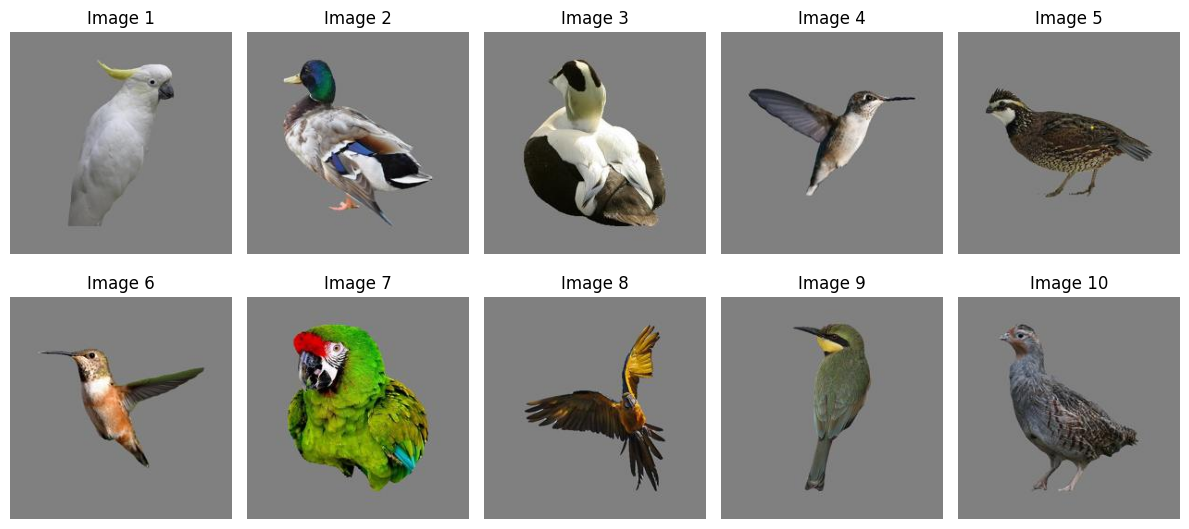

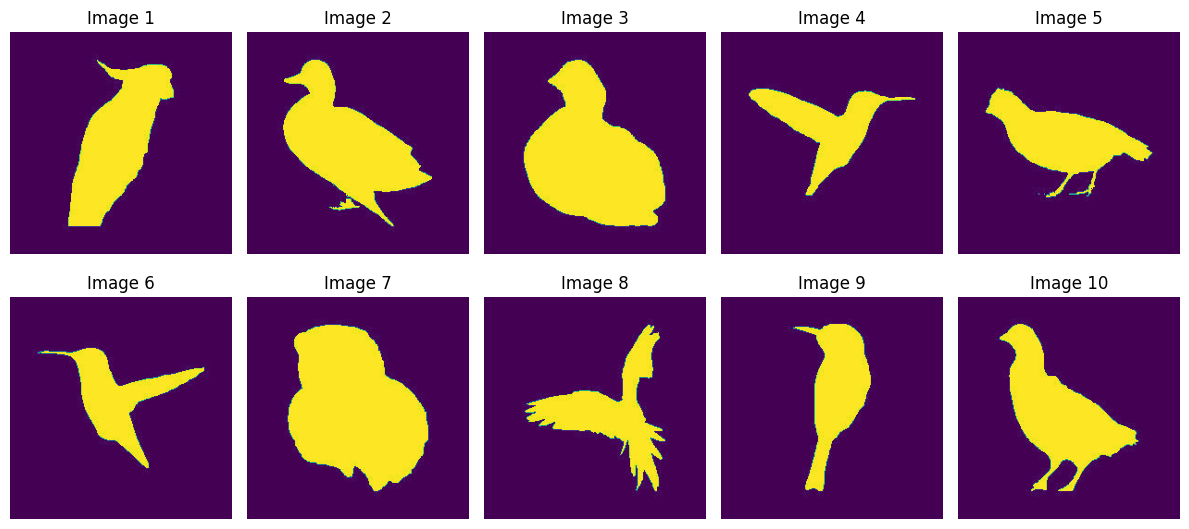

In [52]:
def show_images(imgpathlist, figsize=(12, 6), n_cols=5):

    # Initialize a matplotlib figure
    fig, axes = plt.subplots(math.ceil(len(imgpathlist)/n_cols), n_cols, figsize=figsize)
    plt.subplots_adjust(wspace=0.5)

    # Display the 10 selected images

    for i, image_path in enumerate(imgpathlist):
        image = Image.open(image_path)
        axes[i // n_cols, i % n_cols].imshow(image)
        axes[i // n_cols, i % n_cols].set_title(f"Image {i+1}")
        axes[i // n_cols, i % n_cols].axis('off')

    # Show the images
    plt.tight_layout()
    plt.show()

# Get a list of image file names in the folder
n_images = 10
folder_path = SAVE_IMG_RESIZED/'bird'
imgpathlist = [folder_path/f for f in os.listdir(folder_path)]
imgpathlist = random.sample(imgpathlist, n_images)
show_images(imgpathlist, figsize=(12, 6))
imgpathlist = [Path(str(p).replace(str(SAVE_IMG_RESIZED), str(SAVE_MASK_RESIZED))) for p in imgpathlist]
show_images(imgpathlist,  figsize=(12, 6))

In [36]:
# list used filenames for each category and save as json
filedict = {}
total_images = 0
total_target = 0
SAVE_FINAL = Path('../data/imagenet_val_segmented_resized')

for target in ['cat','dog',  'turtle', 'bird','insect', 'frog', 'primate', 'fish', 'crab',  'nontarget']:
    check_path = SAVE_FINAL/target
    
    # add synset as key
    filedict[target] = {}
    synsetlist = np.unique([path.split('_')[0] for path in os.listdir(check_path)])
    for synset in synsetlist:
        filedict[target][synset] = []

    # add image name to each synset
    pathlist = os.listdir(check_path)
    print(target, '# of images:', len(pathlist))
    total_images += len(pathlist)
    if target != 'nontarget':
        total_target += len(pathlist)
    for path in pathlist:
        synset = path.split('_')[0]
        imgname = '_'.join(path.split('_')[1:])
        filedict[target][synset].append(imgname)

# save as json
with open('../dataset-info/imagenet_val_segmented_after_screening.json', 'w') as f:
    json.dump(filedict, f, indent=4)

print('total images:', total_images)
print('total target images:', total_target)
print('total non-targetimages:', total_images-total_target)

cat # of images: 18
dog # of images: 618
turtle # of images: 42
bird # of images: 90
insect # of images: 34
frog # of images: 17
primate # of images: 15
fish # of images: 29
crab # of images: 8
nontarget # of images: 731
total images: 1602
total target images: 871
total non-targetimages: 731


# Generate blurred objects

In [5]:

from PIL import Image, ImageFilter
SOURCE_IMG_DIR = Path('../data/imagenet_val_segmented_resized')
SAVE_IMG_DIR =  Path('../data/imagenet_val_segmented_resized_blurred')

VISUALIZE = False
SAVE_OUTPUT = True
RADIUS = 5

for cat in ['turtle', 'dog', 'bird', 'insect', 'cat', 'nontarget']:
    print('generating...', cat)
    jpg_files = [file for file in os.listdir(SOURCE_IMG_DIR/cat) if file.lower().endswith(("jpg", "jpeg"))]

    for jpg in tqdm(jpg_files):#['image_0002.jpg']:
        # print(jpg)
        jpg_path = SOURCE_IMG_DIR/cat/jpg
        img = Image.open(jpg_path)
        
        # Apply Gaussian blur
        out_image = img.filter(ImageFilter.GaussianBlur(radius=RADIUS))  # Adjust radius as needed

        if SAVE_OUTPUT:
            newjpg = 'blurred-'+jpg
            if not os.path.exists(SAVE_IMG_DIR/cat):
                os.makedirs(SAVE_IMG_DIR/cat)

            out_image.save(SAVE_IMG_DIR/cat/newjpg)
        
        if VISUALIZE:
            out_arr = np.array(out_image)
            plt.imshow(out_arr)
            plt.show()

generating... turtle


100%|██████████| 42/42 [00:00<00:00, 505.86it/s]


generating... dog


100%|██████████| 618/618 [00:01<00:00, 511.53it/s]


generating... bird


100%|██████████| 90/90 [00:00<00:00, 514.23it/s]


generating... insect


100%|██████████| 34/34 [00:00<00:00, 511.76it/s]


generating... cat


100%|██████████| 18/18 [00:00<00:00, 509.67it/s]


generating... nontarget


100%|██████████| 731/731 [00:01<00:00, 505.09it/s]
